# **Object Detection**

In [ ]:
!pip install transformers
!pip install gradio
!pip install timm
!pip install inflect
!pip install phonemizer

In [ ]:
!sudo apt-get update
!sudo apt-get install espeak-ng
!pip install py-espeak-ng

Get:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,626 B]
Hit:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Get:3 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Hit:4 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:5 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Get:6 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Hit:7 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Get:8 https://r2u.stat.illinois.edu/ubuntu jammy/main amd64 Packages [2,608 kB]
Hit:9 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Get:10 http://security.ubuntu.com/ubuntu jammy-security/restricted amd64 Packages [3,269 kB]
Hit:11 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:12 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [127 kB]
Get:13 http://archive.ubuntu.com/ubuntu jammy-updates/restricted amd

Build the object-detection pipeline using 🤗 Transformers Library¶

- This model was release with the [paper End-to-End Object Detection with Transformers](https://arxiv.org/abs/2005.12872) from Carion et al. (2020)

In [ ]:
import io
import matplotlib.pyplot as plt
import requests
import inflect
from PIL import Image

def load_image_from_url(url):
    return Image.open(requests.get(url, stream=True).raw)

def render_results_in_image(in_pil_img, in_results):
    plt.figure(figsize=(16, 10))
    plt.imshow(in_pil_img)

    ax = plt.gca()

    for prediction in in_results:

        x, y = prediction['box']['xmin'], prediction['box']['ymin']
        w = prediction['box']['xmax'] - prediction['box']['xmin']
        h = prediction['box']['ymax'] - prediction['box']['ymin']

        ax.add_patch(plt.Rectangle((x, y),
                                   w,
                                   h,
                                   fill=False,
                                   color="green",
                                   linewidth=2))
        ax.text(
           x,
           y,
           f"{prediction['label']}: {round(prediction['score']*100, 1)}%",
           color='red'
        )

    plt.axis("off")

    # Save the modified image to a BytesIO object
    img_buf = io.BytesIO()
    plt.savefig(img_buf, format='png',
                bbox_inches='tight',
                pad_inches=0)
    img_buf.seek(0)
    modified_image = Image.open(img_buf)

    # Close the plot to prevent it from being displayed
    plt.close()

    return modified_image

def summarize_predictions_natural_language(predictions):
    summary = {}
    p = inflect.engine()

    for prediction in predictions:
        label = prediction['label']
        if label in summary:
            summary[label] += 1
        else:
            summary[label] = 1

    result_string = "In this image, there are "
    for i, (label, count) in enumerate(summary.items()):
        count_string = p.number_to_words(count)
        result_string += f"{count_string} {label}"
        if count > 1:
          result_string += "s"

        result_string += " "

        if i == len(summary) - 2:
          result_string += "and "

    # Remove the trailing comma and space
    result_string = result_string.rstrip(', ') + "."

    return result_string


##### To ignore warnings #####
import warnings
import logging
from transformers import logging as hf_logging

def ignore_warnings():
    # Ignore specific Python warnings
    warnings.filterwarnings("ignore", message="Some weights of the model checkpoint")
    warnings.filterwarnings("ignore", message="Could not find image processor class")
    warnings.filterwarnings("ignore", message="The `max_size` parameter is deprecated")

    # Adjust logging for libraries using the logging module
    logging.basicConfig(level=logging.ERROR)
    hf_logging.set_verbosity_error()

########

In [ ]:
from transformers import pipeline

In [ ]:
from PIL import Image

In [52]:
pipe = pipeline("object-detection", model="facebook/detr-resnet-50")

Some weights of the model checkpoint at facebook/detr-resnet-50 were not used when initializing DetrForObjectDetection: ['model.backbone.conv_encoder.model.layer1.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer2.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer3.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer4.0.downsample.1.num_batches_tracked']
- This IS expected if you are initializing DetrForObjectDetection from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DetrForObjectDetection from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


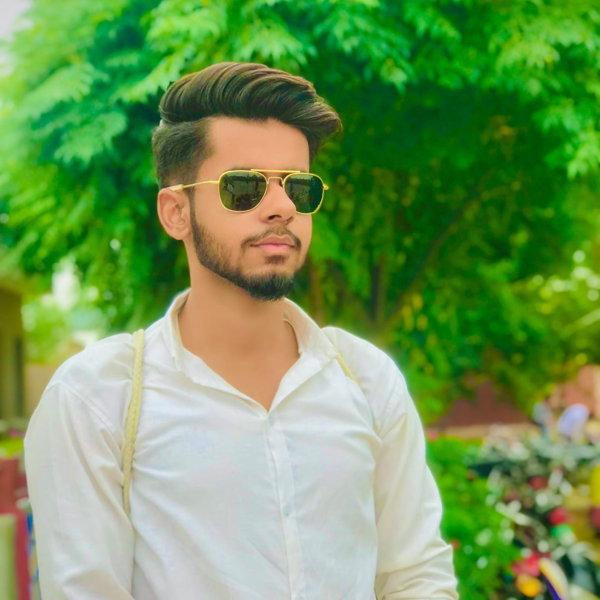

In [38]:
img = Image.open('/content/img.jpeg')
img.resize((600, 600))

In [39]:
pipeline_output = pipe(img)

In [40]:
processed_image = render_results_in_image(
    img,
    pipeline_output)

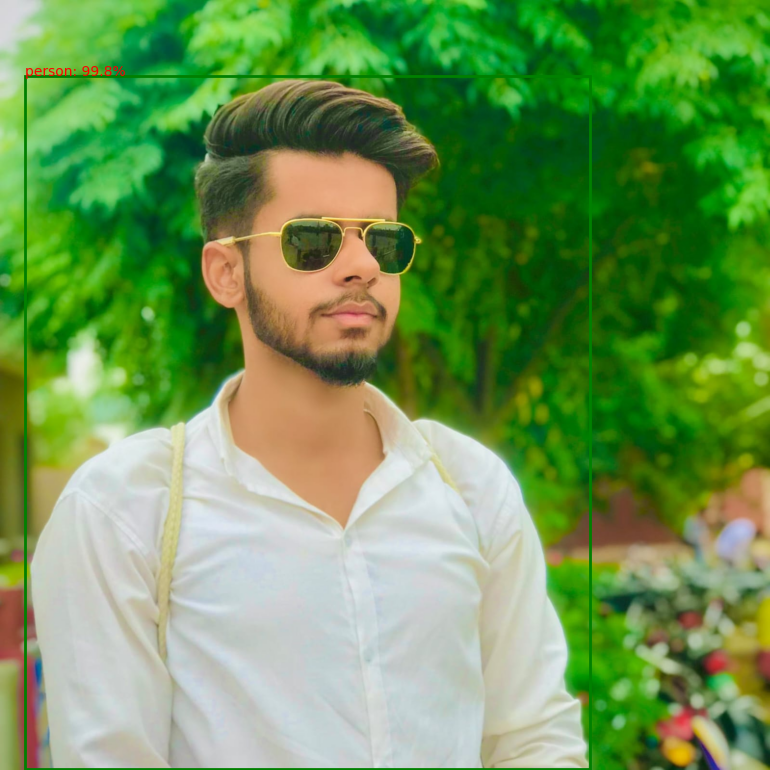

In [41]:
processed_image

In [58]:
img = load_image_from_url('https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcRihzgyn4QEee7LZUJ0yvReaszXfSqUNk7XXg&s')

In [59]:
pipe_line = pipe(img)

In [60]:
processed_image = render_results_in_image(
    img,
    pipe_line)

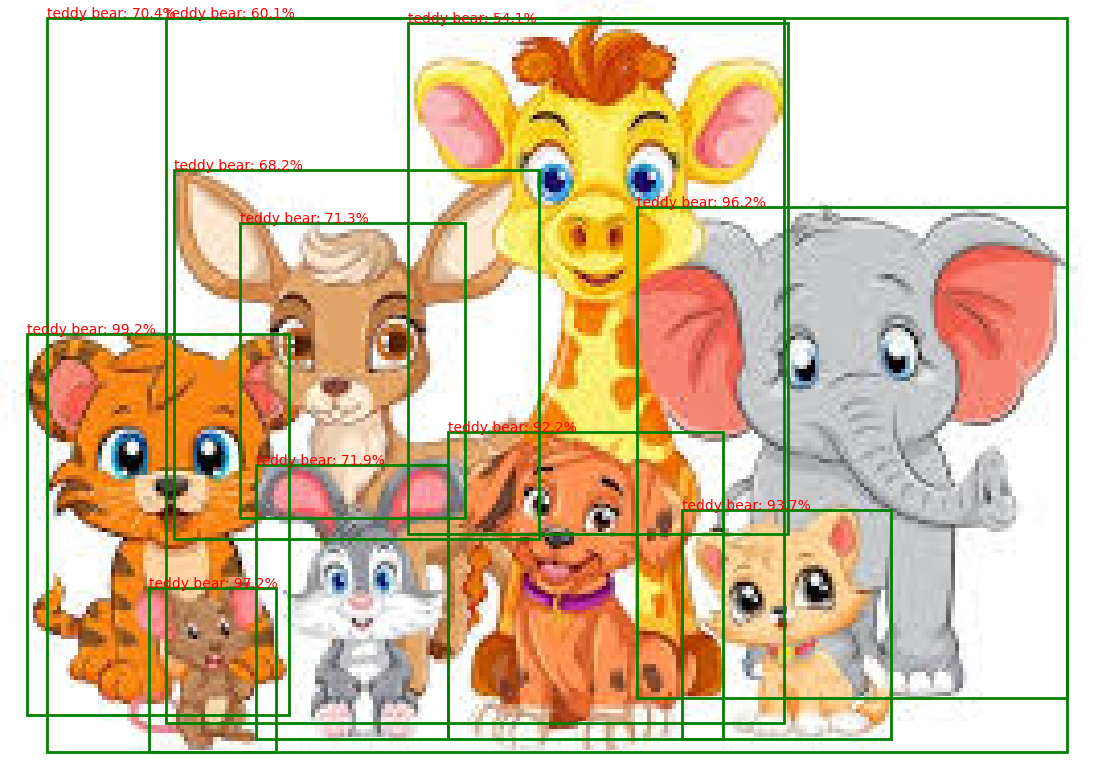

In [55]:
processed_image

In [32]:
import os
import gradio as gr

In [33]:
def get_pipeline_prediction(pil_image):

    pipeline_output = pipe(pil_image)

    processed_image = render_results_in_image(pil_image,
                                            pipeline_output)
    return processed_image

In [34]:
demo = gr.Interface(
  fn=get_pipeline_prediction,
  inputs=gr.Image(label="Input image",
                  type="pil"),
  outputs=gr.Image(label="Output image with predicted instances",
                   type="pil")
)

In [35]:
demo.launch(share=True)

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://28f6bd4feb58cb2272.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


In [37]:
demo.close()

Closing server running on port: 7860


## **Make an AI Powered Audio Assistant¶**
Combine the object detector with a text-to-speech model that will help dictate what is inside the image.

Inspect the output of the object detection pipeline.

In [42]:
pipeline_output

[{'score': 0.997528612613678,
  'label': 'person',
  'box': {'xmin': 52, 'ymin': 157, 'xmax': 1225, 'ymax': 1597}}]

In [61]:
text = summarize_predictions_natural_language(pipe_line)

In [62]:
text

'In this image, there are one person.'

In [45]:
pipe = pipeline("text-to-speech", model="kakao-enterprise/vits-ljs")

config.json:   0%|          | 0.00/1.64k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/145M [00:00<?, ?B/s]

Some weights of the model checkpoint at kakao-enterprise/vits-ljs were not used when initializing VitsModel: ['flow.flows.0.wavenet.in_layers.0.weight_g', 'flow.flows.0.wavenet.in_layers.0.weight_v', 'flow.flows.0.wavenet.in_layers.1.weight_g', 'flow.flows.0.wavenet.in_layers.1.weight_v', 'flow.flows.0.wavenet.in_layers.2.weight_g', 'flow.flows.0.wavenet.in_layers.2.weight_v', 'flow.flows.0.wavenet.in_layers.3.weight_g', 'flow.flows.0.wavenet.in_layers.3.weight_v', 'flow.flows.0.wavenet.res_skip_layers.0.weight_g', 'flow.flows.0.wavenet.res_skip_layers.0.weight_v', 'flow.flows.0.wavenet.res_skip_layers.1.weight_g', 'flow.flows.0.wavenet.res_skip_layers.1.weight_v', 'flow.flows.0.wavenet.res_skip_layers.2.weight_g', 'flow.flows.0.wavenet.res_skip_layers.2.weight_v', 'flow.flows.0.wavenet.res_skip_layers.3.weight_g', 'flow.flows.0.wavenet.res_skip_layers.3.weight_v', 'flow.flows.1.wavenet.in_layers.0.weight_g', 'flow.flows.1.wavenet.in_layers.0.weight_v', 'flow.flows.1.wavenet.in_layers.

tokenizer_config.json:   0%|          | 0.00/285 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/2.14k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/47.0 [00:00<?, ?B/s]

In [46]:
narrated_text = pipe(text)

In [47]:
from IPython.display import Audio as IPythonAudio

In [48]:
IPythonAudio(narrated_text["audio"][0],
             rate=narrated_text["sampling_rate"])